In [1]:
! pip install imutils
! pip install --no-index --find-links=/kaggle/input/tf-efficientnet-whl-files /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=a2712947335e92147ad21c67beee343e53ab68580b084161452b0513cb1756db
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Looking in links: /kaggle/input/tf-efficientnet-whl-files
Processing /kaggle/input/tf-efficientnet-whl-files/efficientnet-1.1.1-py3-none-any.whl
Processing /kaggle/input/tf-efficientnet-whl-files/Keras_Applications-1.0.8-py3-none-any.whl


In [2]:
# Basic Imports 

# Model mathematics
import math
import numpy as np 
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import efficientnet.tfkeras as efn
import pickle

# Plotting libraries
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Utilities
import datetime
import os,sys
import tempfile
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append("/kaggle/input/helper-files")
import random 
import gc
import time
import functools
from imutils import paths
from tqdm import tqdm
from typing import Callable


# SimCLR Losses (extra files, will be explained further in the notebook)
from semi_super_augPipe import preprocess_image
from losses import _dot_simililarity_dim1 as sim_func_dim1, _dot_simililarity_dim2 as sim_func_dim2
import helpers


# Random seed fixation for experiment result repitition
tf.random.set_seed(10)
np.random.seed(10)

print("Tensorflow version : ",tf.__version__)

# In-order run function decorators in tf2.0
tf.config.run_functions_eagerly(False)

# Load the TensorBoard notebook extension
%load_ext tensorboard

Tensorflow version :  2.6.2


In [3]:
import os
import numpy as np
import tensorflow as tf

# Helper functions
@tf.function
def input_image_loader(image):
    image = tf.expand_dims(image, axis=-1)
    image = tf.image.grayscale_to_rgb(image)
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    t = tf.random.uniform(shape=[2], minval=0, maxval=w-384, dtype=tf.int32)
    # view 1 & view 2
    return image[:, t[0]:t[0]+384], image[:, t[1]:t[1]+384]

# Step 1: List all .npy files in the directory
directory = '/kaggle/input/spectogram-v-1-bird-clef'
npy_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

# Step 2: Create a function to load and preprocess .npy files
def load_npy_file(file_path):
    npy_data = np.load(file_path.numpy())
    tensor = tf.convert_to_tensor(npy_data, dtype=tf.float32)
    h, w = tensor.shape
    while w <= 1920:
        w = w * 2
        tensor = tf.concat([tensor, tensor], axis=1)
    return tensor[:, :1920]

# Wrapper function for tf.py_function
def tf_load_npy_file(file_path):
    tensor = tf.py_function(func=load_npy_file, inp=[file_path], Tout=tf.float32)
    return tensor

# Parameters
BATCH_SIZE = 16

# Step 3: Create a TensorFlow dataset from the list of file paths
dataset = tf.data.Dataset.from_tensor_slices(npy_files)

# Step 4: Shuffle the dataset
dataset_shuffled = dataset.shuffle(len(npy_files))

# Step 5: Map the loading function to the dataset
dataset_mapped = dataset_shuffled.map(tf_load_npy_file, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Step 6: Apply the image loader function to the dataset
dataset_processed = dataset_mapped.map(input_image_loader, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Step 7: Batch the dataset
dataset_batched = dataset_processed.batch(BATCH_SIZE, drop_remainder=True)

# Step 8: Prefetch for performance
final_dataset = dataset_batched.prefetch(tf.data.experimental.AUTOTUNE)

# To print a single element, take one element from the dataset
for element in final_dataset.take(1):
    print([e.numpy().shape for e in element])


[(16, 128, 384, 3), (16, 128, 384, 3)]


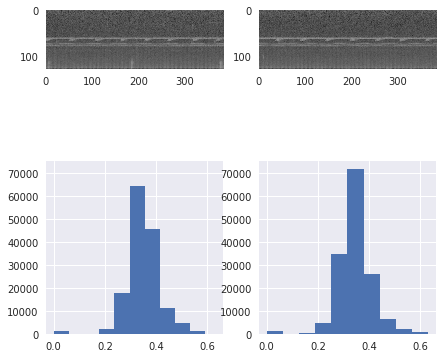

In [4]:
for batch in final_dataset.take(1):
    pass

image_to_viz = 3
plt.figure(figsize=(7, 7))
ax1 = plt.subplot(2, 2, 1)
plt.imshow(batch[0][image_to_viz].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)
ax1.grid(False)
ax2 = plt.subplot(2, 2, 2)
plt.imshow(batch[1][image_to_viz].numpy().astype('float32'), interpolation = 'none', vmin = 0, vmax = 1)
ax2.grid(False)

ax3 = plt.subplot(2, 2, 3)
plt.hist(batch[0][image_to_viz].numpy().ravel())
ax4 = plt.subplot(2, 2, 4, sharey = ax3, sharex=ax3)
plt.hist(batch[1][image_to_viz].numpy().ravel())
plt.show()

In [5]:
# adding l2 reg
def add_regularization(model, regularizer = tf.keras.regularizers.l2(0.0001)):
    """
    Helper function to add l2 regularisation to each layer of a either a preTrained or 
    randomly initialised built in model
    Arguments:
        model : (keras.model) input model 
        regularizer : ( tf.keras.regularizers.l2) object from keras that defines a l2 regularizer
    Returns:
        model : all layers contain the "regularizer" object & incase we pass a pretrained model then the 
                original weights are preserved
    """

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
        print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
        return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    return model

# Architecture utils
def get_simclr(hidden_1, 
               hidden_2, 
               l2_penalty = 10e-6):
    """
    Main function to define the entire network backbone to train
    Arguments:
        hidden_1-2 : (int) variable to define number of neurons in the projection head dense layer
        l2_penalty : (float) to define the amount of l2 penalty applied to each layer's weights
    Returns:
        final_model : (tf.keras.Model) final model that will be trained 
    """
    
    # encoder network
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(128,384,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-imagenet-weights/efficientnet-b0_weights_tf_dim_ordering_tf_kernels_autoaugment_notop.h5')
    regularizer = tf.keras.regularizers.l2(l2_penalty)
    reg_base_model = add_regularization(base_model,regularizer)
    reg_base_model.trainable = True

    # Joining the entire pipeline using functional API
    inputs = Input((128,384, 3))
    h = reg_base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)
    
    # Non linear projection layer to improve the quality of embeddings being produced
    projection_1 = Dense(hidden_1, kernel_regularizer = regularizer)(h)
    projection_1 = tf.keras.layers.BatchNormalization()(projection_1)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2, kernel_regularizer = regularizer)(projection_1)
    projection_2 = tf.keras.layers.BatchNormalization()(projection_2)
    projection_2 = Activation("relu")(projection_2)

    # Final Model
    final_model = Model(inputs, projection_2)
    return final_model

In [6]:
# Mask to remove positive examples from the batch of negative samples
negative_mask = helpers.get_negative_mask(BATCH_SIZE)

Tensorboard logging directory

In [7]:
! rm -rf ./logs
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [8]:
@tf.function
def train_step(xis, 
               xjs, 
               model, 
               optimizer, 
               criterion, 
               temperature):

    with tf.GradientTape() as tape:
        zis = model(xis)
        zjs = model(xjs)

        # normalize projection feature vectors : onto a unit hypersphere
        zis = tf.math.l2_normalize(zis, axis=1)
        zjs = tf.math.l2_normalize(zjs, axis=1)
          
        # calculating over set of all positive pairs ( computing all numerators of softmax)
        l_pos = sim_func_dim1(zis, zjs)
        l_pos = tf.reshape(l_pos, (BATCH_SIZE, 1))

        # temperature scaling
        l_pos /= temperature
        
        # make the batch dimension 2*n
        negatives = tf.concat([zjs, zis], axis=0)

        loss = 0
        for positives in [zis, zjs]:
            # computing similarity with a data point & all the possible negatives
            l_neg = sim_func_dim2(positives, negatives)
            
            # since each data point is its own class
            labels = tf.zeros(BATCH_SIZE, dtype=tf.int32)
            
            # using the negative mask to remove itself & its positve counterpart to compute negative sim
            l_neg = tf.boolean_mask(l_neg, negative_mask)
            l_neg = tf.reshape(l_neg, (BATCH_SIZE, -1))

            # temperature scaling
            l_neg /= temperature

            logits = tf.concat([l_pos, l_neg], axis=1) 
            loss += criterion(y_pred = logits, y_true = labels)

        # since for every data point including its augmentation we compute the loss thus divide by 2*BatchSize
        loss = loss / (2 * BATCH_SIZE)
    
    # Compute & apply the gradients on traininable paramters of the model
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # updated model along with gradients so that we can visualise them on tensorboard.
    return loss, gradients

In [9]:
def train_simclr(model, 
                 train_dataset, 
                 optimizer, 
                 criterion,
                 temperature=0.1, 
                 epochs=100,
                 num_train_samples_viz = 5,
                 num_test_samples_viz = 2):
    
    """
      Training the model function
    """
    
 
    print("Starting training procedure .... : ")
    print("Number of steps per epoch : ",len(train_dataset))
    
    # To measure per epoch time taken
    t_start = time.time()
    
    # Visualisation lists
    lr_epoch = []
    epoch_wise_loss = []

    for epoch in range(0, epochs):
        
        # Reset loss collection each step
        step_wise_loss = []

        # Number of grad descent steps in 1 epoch
        num_train_steps = len(train_dataset) 

        # Picking up random batches & taking first image for input check
        random_batches_train = random.sample(range(len(train_dataset)),num_train_samples_viz)
        cnt = 0

        # Arrays for tensorboard visualisation
        random_collection_train_sample_1 = []
        random_collection_train_sample_2 = []
        gradArray = None
        loss = None 

        # Training loop
        for image_batch in tqdm(train_dataset):
            # Fetching both views for input
            a = image_batch[0]
            b = image_batch[1]

            # Train one batch
            loss, gradArray = train_step(a, b, model, optimizer, criterion, temperature)
            step_wise_loss.append(loss)

            # Check whether to take image from this batch or not
            if cnt in random_batches_train:
                random_collection_train_sample_1.append(image_batch[0][0])
                random_collection_train_sample_2.append(image_batch[1][0])
            cnt+=1
        
        # Average loss throughout the whole process
        if not len(epoch_wise_loss):
            epoch_wise_loss.append(np.mean(step_wise_loss))
        else:
            # Adding the mean of previous ones
            mean_value = (np.sum(step_wise_loss) + epoch_wise_loss[-1]*(epoch)*num_train_steps)/((epoch+1)*num_train_steps)
            epoch_wise_loss.append(mean_value)
        
        # Printing the loss progression
        print("\n epoch: {} | train loss: {:.8f} | lr : {} | {:.4f} mins"
              .format(epoch + 1,epoch_wise_loss[-1],optimizer._decayed_lr(tf.float32).numpy(), (time.time()-t_start)/60.0))    
   
        # Appending the value of learning rate for warmup + cosine decay visualisation
        lr_epoch.append(optimizer._decayed_lr(tf.float32).numpy())
        
        # Tensorfboard visualisations
#         tf.summary.experimental.set_step(epoch)
#         with train_summary_writer.as_default():
#             tf.summary.scalar('LOSS', epoch_wise_loss[-1], step=epoch)
#             tf.summary.scalar('LEARNING RATE PROGRESSION', lr_epoch[-1], step = epoch)
#             tf.summary.image('VIEW 1', random_collection_train_sample_1, step=epoch)
#             tf.summary.image('VIEW 2', random_collection_train_sample_2, step=epoch)

#             # global variable defined later
#             for name in layer_names:
#                 tf.summary.histogram(name+"_gradients",gradArray[layer_to_index[name]])
                
#             for layer in model.layers:
#                 for tl in layer.trainable_weights:
#                     if tl.name in layer_names:
#                         tf.summary.histogram(tl.name+"_weights",tl.numpy())
        
        # saving models 
        print("Saving Base Model.....")
        
        # Saving the entire model for checkpointing reasons
        model.save("./" + modelNameStr + ".h5")

        # saving the state of optimizer
        np.save("./" + modelNameStr + "_optimizer.npy", optimizer.get_weights())

    
    return epoch_wise_loss, model

In [10]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,
               initial_learning_rate: float,
               decay_schedule_fn: Callable,
               warmup_steps: int,
               power: float = 1.0,
               name: str = None,):
    
    super().__init__()
    self.initial_learning_rate = initial_learning_rate
    self.warmup_steps = warmup_steps
    self.power = power
    self.decay_schedule_fn = decay_schedule_fn
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "WarmUp") as name:
        # Implements polynomial warmup. i.e., if global_step < warmup_steps, the
        # learning rate will be `global_step/num_warmup_steps * init_lr`.
        global_step_float = tf.cast(step, tf.float32)
        warmup_steps_float = tf.cast(self.warmup_steps, tf.float32)
        warmup_percent_done = global_step_float / warmup_steps_float
        warmup_learning_rate = self.initial_learning_rate * tf.math.pow(warmup_percent_done, self.power)
        return tf.cond(
            global_step_float < warmup_steps_float,
            lambda: warmup_learning_rate,
            lambda: self.decay_schedule_fn(step - self.warmup_steps),
            name=name,
        )

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "decay_schedule_fn": self.decay_schedule_fn,
        "warmup_steps": self.warmup_steps,
        "power": self.power,
        "name": self.name,
    }

In [11]:
# Defining the loss function
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                          reduction=tf.keras.losses.Reduction.SUM)
# Number of epochs
tot_epochs = 50

# temperature in NTXent
loss_temp = 0.2

# Defining the SimCLR model
# Differentiating models via their hyper-parameter values
modelNameStr = "pretraining_on_unlabeled"
print("ModelName : ",modelNameStr) 
simclr_2 = get_simclr(256, 256)


# optimiser decay schedule
decay_steps = (len(final_dataset))*tot_epochs
warmup_steps = (len(final_dataset))*10
initial_lr = 0.5e-3

# Cosine decay function
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate = initial_lr, 
                                                  decay_steps = decay_steps)
cosine_with_warmUp = WarmUp(initial_learning_rate = initial_lr,
                            decay_schedule_fn = lr_decayed_fn,
                            warmup_steps = warmup_steps)

print("Decay Steps : ",decay_steps)
optimizer = tf.keras.optimizers.Adam(cosine_with_warmUp)

# Learning a layer to number mapping for kernel weight & gradient visualisation of last few CNN layers & projection head
tot = []
for i in simclr_2.layers:
  for j in i.trainable_weights:
    tot.append(j.name)
cnt = 0

layer_names = [tot[-23], tot[-20], tot[-16], tot[-12], tot[-8], tot[-4]]
print(layer_names)
index_to_layer = {}
for i in simclr_2.layers:
  for j in i.trainable_weights:
    index_to_layer[cnt] = j.name
    cnt+=1
layer_to_index = {j:i for i,j in index_to_layer.items()}

ModelName :  pretraining_on_unlabeled


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Decay Steps :  19050
['block7a_expand_bn/gamma:0', 'block7a_bn/gamma:0', 'block7a_se_expand/kernel:0', 'block7a_project_bn/beta:0', 'dense/kernel:0', 'dense_1/kernel:0']


In [12]:
simclr_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 384, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 4, 12, 1280)       4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792 

In [13]:
epoch_wise_loss, final_simCLR  = train_simclr(simclr_2, 
                                              final_dataset,
                                              optimizer, 
                                              criterion,
                                              temperature= loss_temp, 
                                              epochs = tot_epochs)

Starting training procedure .... : 
Number of steps per epoch :  381


100%|██████████| 381/381 [02:11<00:00,  2.90it/s]



 epoch: 1 | train loss: 1.99117124 | lr : 5.000000601285137e-05 | 2.1871 mins
Saving Base Model.....


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 2 | train loss: 1.40374814 | lr : 0.00010000001202570274 | 4.5615 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 3 | train loss: 1.10431236 | lr : 0.00015000002167653292 | 6.9363 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 4 | train loss: 0.93489198 | lr : 0.00020000000949949026 | 9.3117 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.26it/s]



 epoch: 5 | train loss: 0.82529036 | lr : 0.0002500000118743628 | 10.8145 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.26it/s]



 epoch: 6 | train loss: 0.74875224 | lr : 0.0003000000142492354 | 12.3160 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.25it/s]



 epoch: 7 | train loss: 0.69402622 | lr : 0.0003499999875202775 | 13.8196 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 8 | train loss: 0.65159305 | lr : 0.0004000000189989805 | 16.1943 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.26it/s]



 epoch: 9 | train loss: 0.61801432 | lr : 0.0004500000213738531 | 17.6975 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 10 | train loss: 0.59314909 | lr : 0.0005000000237487257 | 20.0724 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 11 | train loss: 0.57024619 | lr : 0.000499506713822484 | 22.4472 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 12 | train loss: 0.55010453 | lr : 0.0004980287048965693 | 24.8224 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.25it/s]



 epoch: 13 | train loss: 0.53319692 | lr : 0.0004955718177370727 | 26.3295 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.25it/s]



 epoch: 14 | train loss: 0.51806555 | lr : 0.0004921457730233669 | 27.8342 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 15 | train loss: 0.50468545 | lr : 0.00048776413314044476 | 30.2090 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 16 | train loss: 0.49261022 | lr : 0.0004824441275559366 | 32.5839 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.26it/s]



 epoch: 17 | train loss: 0.48125619 | lr : 0.0004762067983392626 | 34.0876 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.27it/s]



 epoch: 18 | train loss: 0.47154465 | lr : 0.00046907670912332833 | 35.5877 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.25it/s]



 epoch: 19 | train loss: 0.46236921 | lr : 0.0004610820033121854 | 37.0917 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.24it/s]



 epoch: 20 | train loss: 0.45408169 | lr : 0.0004522542585618794 | 38.6004 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.25it/s]



 epoch: 21 | train loss: 0.44620195 | lr : 0.00044262834126129746 | 40.1044 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 22 | train loss: 0.43888031 | lr : 0.00043224217370152473 | 42.4791 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.24it/s]



 epoch: 23 | train loss: 0.43193012 | lr : 0.00042113682138733566 | 43.9890 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 24 | train loss: 0.42525871 | lr : 0.0004093560273759067 | 46.3679 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.21it/s]



 epoch: 25 | train loss: 0.41905772 | lr : 0.0003969463286921382 | 47.8879 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 26 | train loss: 0.41345004 | lr : 0.00038395667797885835 | 50.2626 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.21it/s]



 epoch: 27 | train loss: 0.40803219 | lr : 0.00037043841439299285 | 51.7838 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.23it/s]



 epoch: 28 | train loss: 0.40301971 | lr : 0.000356444827048108 | 53.2948 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 29 | train loss: 0.39830092 | lr : 0.00034203112591058016 | 55.6698 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 30 | train loss: 0.39370657 | lr : 0.00032725423807278275 | 58.0457 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.22it/s]



 epoch: 31 | train loss: 0.38940635 | lr : 0.0003121725167147815 | 59.5616 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 32 | train loss: 0.38514533 | lr : 0.0002968453336507082 | 61.9362 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 33 | train loss: 0.38106095 | lr : 0.0002813332830555737 | 64.3115 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 34 | train loss: 0.37735580 | lr : 0.00026569762849248946 | 66.6870 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 35 | train loss: 0.37360175 | lr : 0.00024999998277053237 | 69.0625 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 36 | train loss: 0.36999596 | lr : 0.0002343023952562362 | 71.4379 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 37 | train loss: 0.36649714 | lr : 0.00021866668248549104 | 73.8133 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.24it/s]



 epoch: 38 | train loss: 0.36329146 | lr : 0.00020315467554610223 | 75.3232 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.23it/s]



 epoch: 39 | train loss: 0.36007816 | lr : 0.0001878275361377746 | 76.8355 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 40 | train loss: 0.35702414 | lr : 0.00017274571291636676 | 79.2111 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 41 | train loss: 0.35400431 | lr : 0.0001579688541823998 | 81.5865 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 42 | train loss: 0.35117960 | lr : 0.00014355516759678721 | 83.9621 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 43 | train loss: 0.34847509 | lr : 0.00012956155114807189 | 86.3382 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 44 | train loss: 0.34576533 | lr : 0.00011604327301029116 | 88.7143 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.21it/s]



 epoch: 45 | train loss: 0.34328629 | lr : 0.00010305369505658746 | 90.2348 mins
Saving Base Model.....


100%|██████████| 381/381 [01:30<00:00,  4.22it/s]



 epoch: 46 | train loss: 0.34086369 | lr : 9.064395999303088e-05 | 91.7497 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 47 | train loss: 0.33833711 | lr : 7.886322418926284e-05 | 94.1251 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 48 | train loss: 0.33601168 | lr : 6.775785004720092e-05 | 96.5004 mins
Saving Base Model.....


100%|██████████| 381/381 [01:29<00:00,  4.24it/s]



 epoch: 49 | train loss: 0.33379986 | lr : 5.737167884944938e-05 | 98.0112 mins
Saving Base Model.....


100%|██████████| 381/381 [02:21<00:00,  2.68it/s]



 epoch: 50 | train loss: 0.33168156 | lr : 4.77457360830158e-05 | 100.3867 mins
Saving Base Model.....
